# Benchmarking Analysis for Multiview Hypothesis Testers

Here, we are interested in analyzing the performance of using multi-view trees in the presence
of two views of data, when one of the datasets has a significantly greater number of dimensions.

For example, in liquid biopsies from cancer patients, we might obtain features describing the
fragment lengths of DNA found, or a description of the fragment ends (e.g. what is the ratio of base-pairs
found at the end). These might have wildly different dimensionalities like 1000 vs 10,000 if we consider
different levels of complexities of each of these biological characteristics.

So we want a hypothesis test that is i) aware of the fact that ``X`` is comprised of two feature-sets, and ii)
is able to handle wildly different dimensionalities in each of the feature-sets with sufficient power
and type-I error rate to provide useful answers to cancer biomarker hypotheses.

The `make_classification` experiment stems from: http://clopinet.com/isabelle/Projects/NIPS2003/Slides/NIPS2003-Datasets.pdf

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [3]:
print("done")

done


# Simulate data with varying dimensionality

Here, we will implement a function to simulate data with a varying number of dimensions in the second view.

We will implement a simulation that leverages two views stemming from the graphical model:

$(X1 \rightarrow Y \leftarrow X2; X1 \leftrightarrow X2)$

or

$(X1 \rightarrow Y \leftarrow X2)$

where X1 and X2 are two views and Y is the target variable. The bidirected edge between X1 and X2 is just to allow the two views to
be potentially correlated. 

We will also use the package `mvlearn` to simulate a two-view dataset using their `make_gaussian_mixture` function (https://mvlearn.github.io/references/datasets.html#data-simulator). This simulates a ``X`` and a ``y``, and then applies a transformation on ``X``, which produces the second view. This stems from the graphical model:

$(X1 \rightarrow Y \leftarrow X2; X1 \rightarrow X2)$

where X1 is the original dataset and X2 is the transformed dataset.

## Data-generating model with views correlated by a direct effect

In [41]:
n_samples = 500
noise_dims = 80
n_features = 100 - noise_dims
n_features_2 = 10000 - noise_dims

max_features = "sqrt"
n_estimators = 500
n_jobs = -1
test_size = 0.2

n_repeats = 5

max_fpr = 0.1

In [10]:
class_probs = [0.75, 0.25]

In [21]:
def make_multiview_dataset(
    n_features=50,
    n_features_2=50,
    noise_dims=50,
    n_samples=100,
    seed=None,
    transform="linear",
    class_probs=None,
):
    fixed_center = rng.standard_normal(size=(n_features,))
    # centers = [
    #     rng.standard_normal(size=(n_features,)),
    #     rng.standard_normal(size=(n_features,)),
    # ]
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    # covariances = [
    #     make_sparse_spd_matrix(n_features, random_state=seed),
    #     make_sparse_spd_matrix(n_features, random_state=seed + 123),
    # ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
    )

    X = np.hstack(
        (Xs[1], Xs[0], rng.standard_normal(size=(n_samples, n_features_2 - n_features)))
    )
    n_features_ends = [
        n_features + noise_dims,
        n_features_2 + n_features + noise_dims * 2,
    ]
    return X, y, n_features_ends

In [17]:
X, y, n_features_ends = make_multiview_dataset(
    n_features=n_features,
    n_features_2=n_features_2,
    noise_dims=noise_dims,
    n_samples=n_samples,
    seed=seed,
    transform="sin",
    class_probs=class_probs,
)
print(X.shape)

est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic
stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

print(stat, stat_rf)

(500, 100) (500, 100)
(500, 10100)
0.7431578947368421 0.5621052631578948


In [42]:
n_features_2_list = np.linspace(500 - noise_dims, 10_000 - noise_dims, 10, dtype=int)
print(n_features_2_list)

[ 420 1475 2531 3586 4642 5697 6753 7808 8864 9920]


In [43]:
results = defaultdict(list)


for idx in range(n_repeats):
    n_features_begin = 0
    X = np.empty((n_samples, 0))
    y = np.empty((n_samples, 0))

    for n_features_2_ in n_features_2_list:
        _X, _y, n_features_ends = make_multiview_dataset(
            n_features=n_features,
            n_features_2=n_features_2_,
            noise_dims=noise_dims,
            n_samples=n_samples,
            seed=seed + idx + n_features_2_,
            transform="sin",
            class_probs=class_probs,
        )
        # stack features
        # print(X.shape, _X.shape)
        X = _X
        y = _y
        # X = np.hstack((X, _X[:, n_features_begin:]))
        # y = _y.copy()
        # n_features_begin = X.shape[1]

        print(
            "New dataset: ",
            n_features_2_,
            n_features_ends,
            X.shape,
            y.shape,
            n_features_begin,
        )

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)
    # break

New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  9920 [100, 10100] (500, 10100) (500,) 0
New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  99

In [44]:
df = pd.DataFrame(results)

In [45]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [46]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,420,80,500,rf,0.764211
1,1475,80,500,rf,0.769825
2,2531,80,500,rf,0.661754
3,3586,80,500,rf,0.622456
4,4642,80,500,rf,0.664561


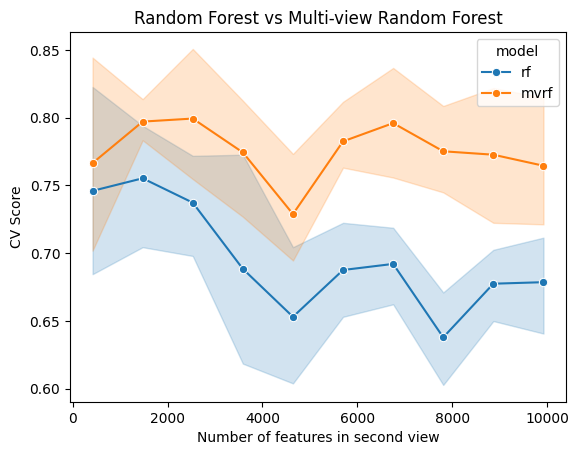

In [47]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

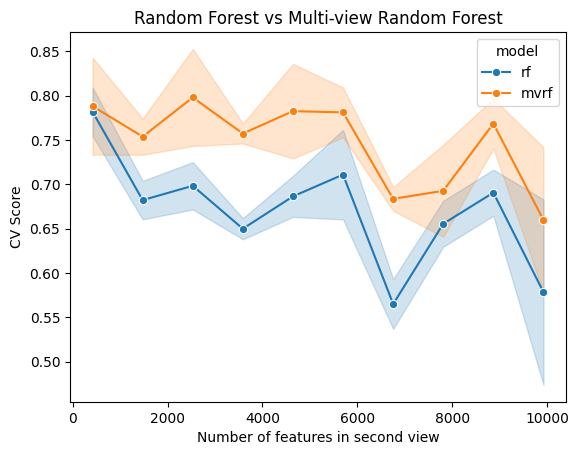

In [17]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

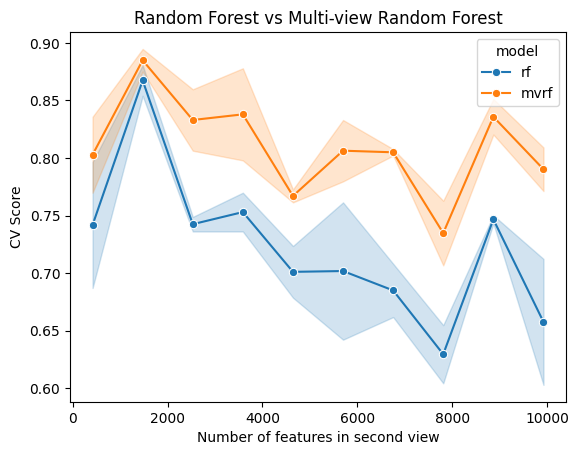

In [140]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

These are some other plots you can generate by playing around with the parameterizations of the data-generating model.

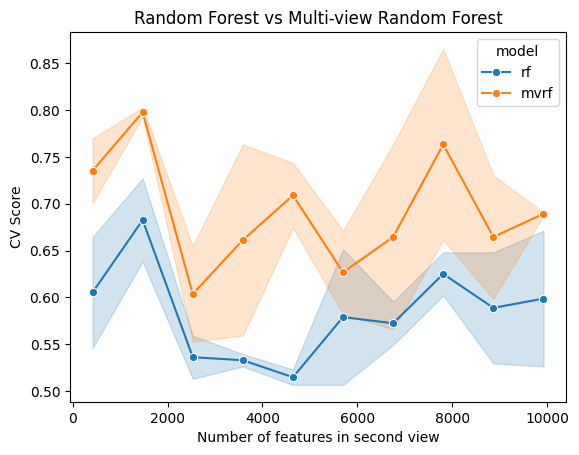

In [127]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

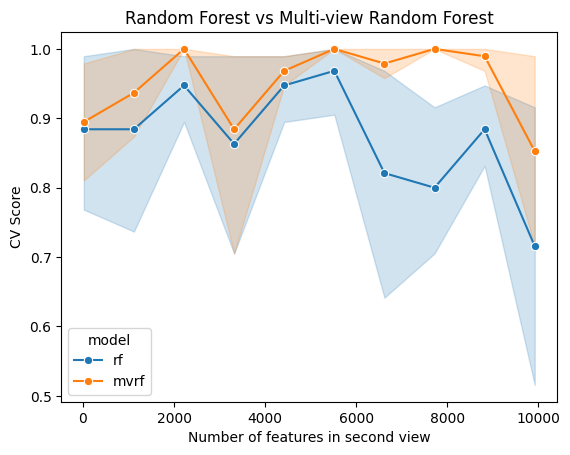

In [39]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

## Data-generating model with correlated views from a latent factor

Here, we proceed by simulating views that are independent, but both predictive of `y`.

In [181]:
def make_multiview_classification(
    n_samples=100,
    n_features_1=100,
    n_features_2=1000,
    noise_dims=20,
    cluster_std_first=2.0,
    cluster_std_second=5.0,
    X0_first=None,
    y0=None,
    X1_first=None,
    y1=None,
    seed=None,
):
    rng = np.random.default_rng(seed=seed)

    if X0_first is None and y0 is None:
        # Create a high-dimensional multiview dataset with a low-dimensional informative
        # subspace in one view of the dataset.
        X0_first, y0 = make_blobs(
            n_samples=n_samples,
            cluster_std=cluster_std_first,
            n_features=n_features_1 - noise_dims,
            center_box=(0, 0),
            random_state=seed,
            centers=1,
        )

        X1_first, y1 = make_blobs(
            n_samples=n_samples,
            cluster_std=cluster_std_second,
            n_features=n_features_2 - noise_dims,
            center_box=(-5, 5),
            random_state=seed + 1,
            centers=1,
        )
    # X0_first = X0_first + rng.standard_normal(size=X0_first.shape) // 10
    # X1_first = X1_first + rng.standard_normal(size=X1_first.shape) // 10
    X0 = np.concatenate(
        [X0_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    )
    X1 = np.concatenate(
        [X1_first, rng.standard_normal(size=(n_samples, noise_dims))], axis=1
    )

    X = np.hstack((X0, X1))

    # y = expit(X0_first[:, :n_features_1//2] + X1_first[:, :n_features_1//2]
    y = rng.binomial(
        n=1, p=expit(X0_first[:, :10].sum(axis=1)), size=n_samples
    ) * rng.binomial(n=1, p=expit(X1_first[:, :10].sum(axis=1)), size=n_samples)
    # y = np.hstack((y0, y1)).T

    # X = X + rng.standard_normal(size=X.shape)

    return X, y

In [268]:
noise_dims = 90
n_estimators = 200
n_features = 100
max_features = "sqrt"
n_features_2 = 1000 - n_features
n_samples = 200

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features + n_features_2,
    n_informative=20,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    shuffle=True,
    random_state=seed,
)
n_features_ends = [10, X.shape[1]]

# n_features_ends = [n_features, n_features+ n_features_2]
# print(n_features, n_features_2, noise_dims, n_features_ends)
print(X.shape, y.shape, np.sum(y) / n_samples)

(200, 1000) (200,) 0.5


In [266]:
X, y = make_classification(
    n_samples=n_samples,
    n_features=10000,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    class_sep=2.0,
    flip_y=0.05,
    shuffle=False,
    random_state=seed,
)
n_features_ends = [20, X.shape[1]]
print(n_features_ends)
print(X.shape, np.sum(y) / n_samples)

est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            max_features=max_features,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(max_features=max_features),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic
stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

print(stat, stat_rf)

[20, 10000]
(200, 10000) 0.49
0.5526315789473684 0.5394736842105263


In [269]:
print(n_features_2_list)

[ 420 1475 2531 3586 4642 5697 6753 7808 8864 9920]


In [277]:
results = defaultdict(list)

for n_features_2_ in n_features_2_list:
    for idx in range(5):
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features_2_ + 20,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=2,
            class_sep=2.0,
            flip_y=0.05,
            shuffle=False,
            random_state=seed + idx + n_features_2_,
        )
        n_features_ends = [20, X.shape[1]]

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)

In [278]:
df = pd.DataFrame(results)

In [279]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features_2", "noise_dims", "n_samples"],
    var_name="model",
    value_name="score",
)

In [280]:
display(df.head())

,n_features_2,noise_dims,n_samples,model,score
0,420,90,200,rf,0.592105
1,420,90,200,rf,0.725630
2,420,90,200,rf,0.986842
3,420,90,200,rf,0.799499
4,420,90,200,rf,0.618421


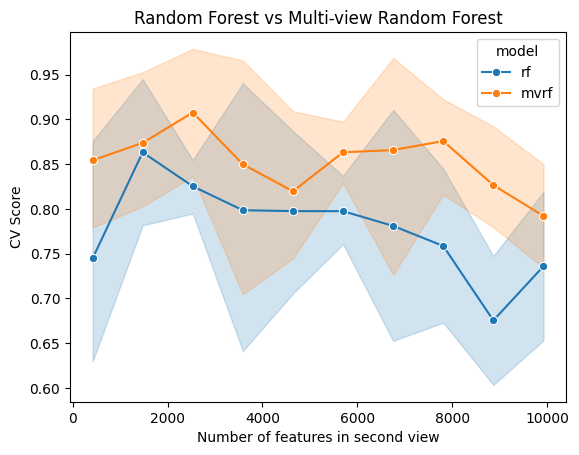

In [281]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features_2", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("CV Score")
ax.set_xlabel("Number of features in second view")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()